In [11]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
import sigmf
from data_path import data_path

plt.rcParams['font.size'] = 14
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['figure.figsize'] = (10, 5)

In [12]:
# handle = sigmf.sigmffile.fromfile(data_path + '/763MHz_15360KSPS.sigmf-data')
# delta_f = 450e3
# f = 763e6
# mu = 0
# samp_rate_error = 1
# apply_fine_CFO = 1

handle = sigmf.sigmffile.fromfile(data_path + '/3627MHz_30720KSPS.sigmf-data')
delta_f = -600e3
f = 3672e6
mu = 1
samp_rate_error = 1 - 1e3/3672e6
apply_fine_CFO = 1

# handle = sigmf.sigmffile.fromfile('30720KSPS_dl_signal.sigmf-data')
# delta_f = 0
# f = 1
# mu = 0
# samp_rate_error = 1
# apply_fine_CFO = 0  # why does fine_CFO fail for perfect input file??

x_orig = handle.read_samples()
x_orig /= max(x_orig.real.max(), x_orig.imag.max()) # scale max amplitude to 1
fs = handle.get_global_field(sigmf.SigMFFile.SAMPLE_RATE_KEY)



In [13]:
# The units here are samples
SCS = 15e3 * 2**mu
Tu = int(fs/SCS) # useful time of a symbol
cp1 = int(5.2e-6*fs * 2**(-mu))
cp2 = int(4.7e-6*fs * 2**(-mu))

In [14]:
# defined in 3GPP TS 38.211 version 16.3.0 Release 16
# verified with nrPSS() in Matlab
def calc_PSS(N_id_2):
    n = 127
    x = np.zeros(n, 'int32')    # m-sequence
    x[0:7] = np.array([0, 1, 1, 0, 1, 1, 1])
    for i in np.arange(0, 127 - 7):
        x[i+7] = (x[i + 4] + x[i]) % 2
    d_PSS = np.zeros(n, 'int32')
    for n in np.arange(0, 127):
        m = (n + 43*N_id_2) % 127  # offset based on N_id_2
        d_PSS[n] = 1 - 2*x[m]  # BPSK modulation
    return d_PSS

In [15]:
PSS = [calc_PSS(0), calc_PSS(1), calc_PSS(2)]
subcarriers_ss = slice(Tu//2 - 1 - 63, Tu//2 - 1 + 64)
PSS_time = np.empty((3, Tu), 'complex')
PSS_time_coarse = np.empty((3, Tu), 'complex')
for j in range(PSS_time.shape[0]):
    PSS_all = np.zeros(Tu, 'complex')
    PSS_all[subcarriers_ss] = PSS[j]
    PSS_time[j] = np.fft.ifft(np.fft.fftshift(PSS_all))
    PSS_time_coarse[j] = PSS_time[j] * np.exp(1j*(2*np.pi*delta_f/fs*np.arange(PSS_time.shape[1])))  


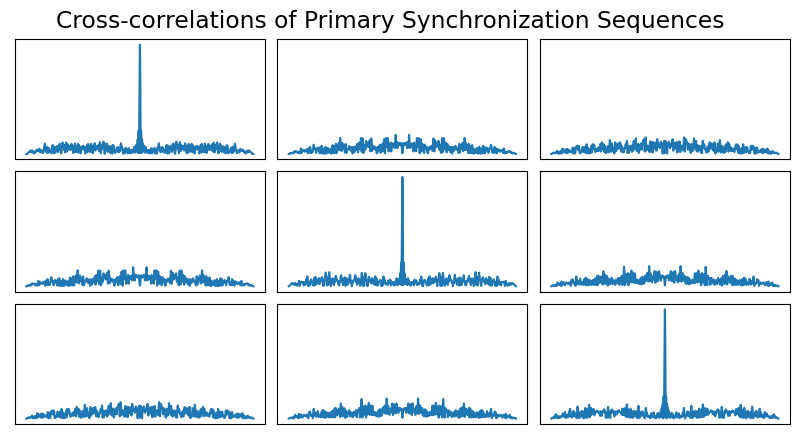

In [16]:
fig, axs = plt.subplots(3, 3, facecolor='w', sharex=True, sharey=True)
for j in range(3):
    for k in range(3):
        axs[j, k].plot(np.abs(np.correlate(PSS_time[j], PSS_time[k], mode='full')))
        axs[j, k].set_xticks([])
        axs[j, k].set_yticks([])
plt.suptitle('Cross-correlations of Primary Synchronization Sequences', y=0.94)
plt.subplots_adjust(wspace=0.05, hspace=0.1)

In [17]:
PSS_corr = np.empty((3, int(25e-3 * fs)), 'complex') # do cross correlation for 25 ms, bcs SSB comes every 20 ms
for j in range(PSS_corr.shape[1]):
    PSS_corr[:, j] = np.sum(x_orig[j:][:Tu] * np.conjugate(PSS_time_coarse), axis=1)
t_corr = np.arange(PSS_corr.shape[1])/fs

Text(0.5, 0.93, 'Cross-correlation of signal with Primary Synchronization Sequences')

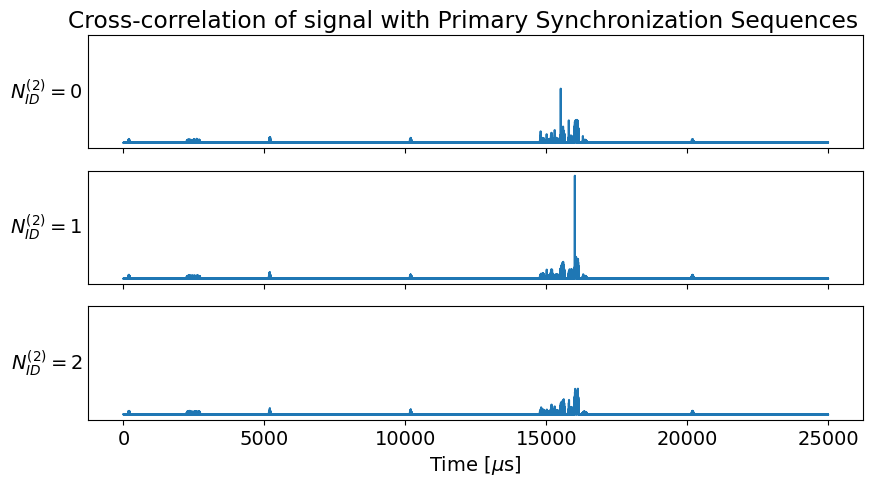

In [18]:
fig, axs = plt.subplots(3, 1, facecolor='w', sharex=True, sharey=True)
for j, ax in enumerate(axs.ravel(order='F')):
    ax.plot(t_corr*1e6, np.abs(PSS_corr[j]))
    ax.set_yticks([])
    ax.set_ylabel(f'$N_{{ID}}^{{(2)}} = {j}$', rotation=0,
        horizontalalignment='right', verticalalignment='center')
axs[-1].set_xlabel('Time [$\mu$s]')
plt.suptitle('Cross-correlation of signal with Primary Synchronization Sequences', y=0.93)

In [19]:
idx, a0 = np.unravel_index(np.argmax(np.abs(PSS_corr)), PSS_corr.shape)
N_id_2 = idx
N_id_2, idx, a0

(1, 1, 492020)

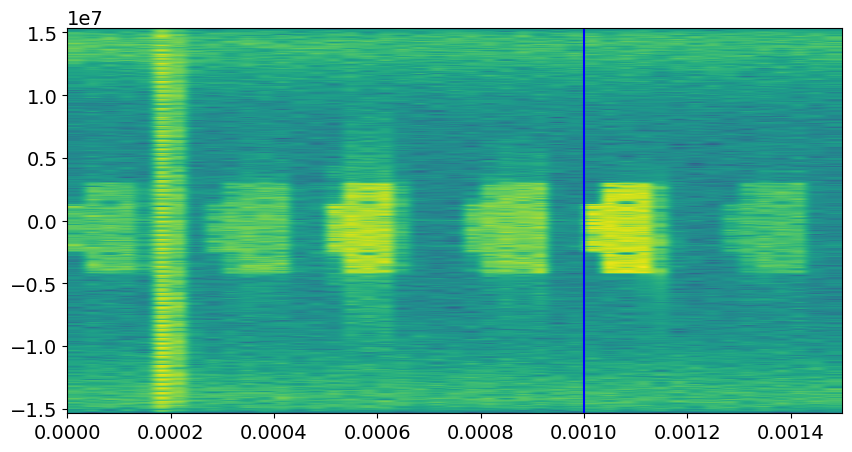

In [20]:
nFFT = Tu
x0 = max(0, a0 - 1E-3*fs) # display 1 ms before detected PSS
plt.specgram(x_orig[int(x0):int(x0)+nFFT*45], Fs=fs, NFFT=nFFT, noverlap=0)
#plt.specgram(x_orig, Fs=fs, NFFT=nFFT, noverlap=0)
a0_time = (a0-x0)/fs
plt.axvline(x = a0_time, color = 'b', label = 'axvline - full height')

In [21]:
#delta_f = 450e3
#delta_f = 0
x_coarse =  x_orig[a0-cp2:] * np.exp(-1j*2*np.pi*delta_f/fs*(np.arange(len(x_orig[a0-cp2:]))))
# fine CFO
# tuns out this is accurate to about +-4 Hz
# 3627MHz_30720KSPS.sigmf-data needs -2.5 Hz additional correction to be perfect
C0 =  np.sum(x_coarse[cp2:][:Tu//2] * np.conjugate(PSS_time[N_id_2][:Tu//2]))
C1 = np.sum(x_coarse[cp2:][Tu//2:Tu] * np.conjugate(PSS_time[N_id_2][-Tu//2:]))
cfo_hz_max = fs/(Tu/2)
delta_phi = -np.arctan(np.imag(C1*np.conjugate(C0))/np.real(C1*np.conjugate(C0)))/(2*np.pi)*cfo_hz_max
print(f"PSS based fine CFO {delta_phi:.03f} Hz")
if False:
    x = x_coarse * np.exp(1j*(2*np.pi*(-delta_phi)/fs*(np.arange(len(x_coarse)))))
else:
    x = x_coarse

PSS based fine CFO -748.658 Hz


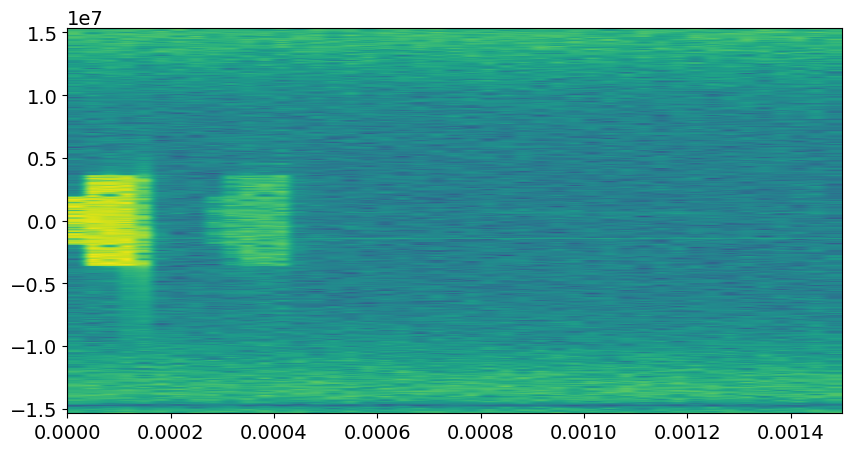

In [22]:
nFFT = Tu
x0 = a0 # display starting with detected PSS
plt.specgram(x_coarse[:nFFT*45], Fs=fs, NFFT=nFFT, noverlap=0)
#plt.specgram(x_orig, Fs=fs, NFFT=nFFT, noverlap=0)
a0_time = (a0-x0)/fs
plt.axvline(x = a0_time, color = 'b', label = 'axvline - full height')

resample from 1846489 to 1846483 samples
fine CFO is 10057.88085883568 Hz
delay is -0.014824989345322868 = -0.4941663115107623 us
delay is -0.012519492085814017 = -0.4173164028604673 us
delay is -0.010268397628232383 = -0.34227992094107945 us


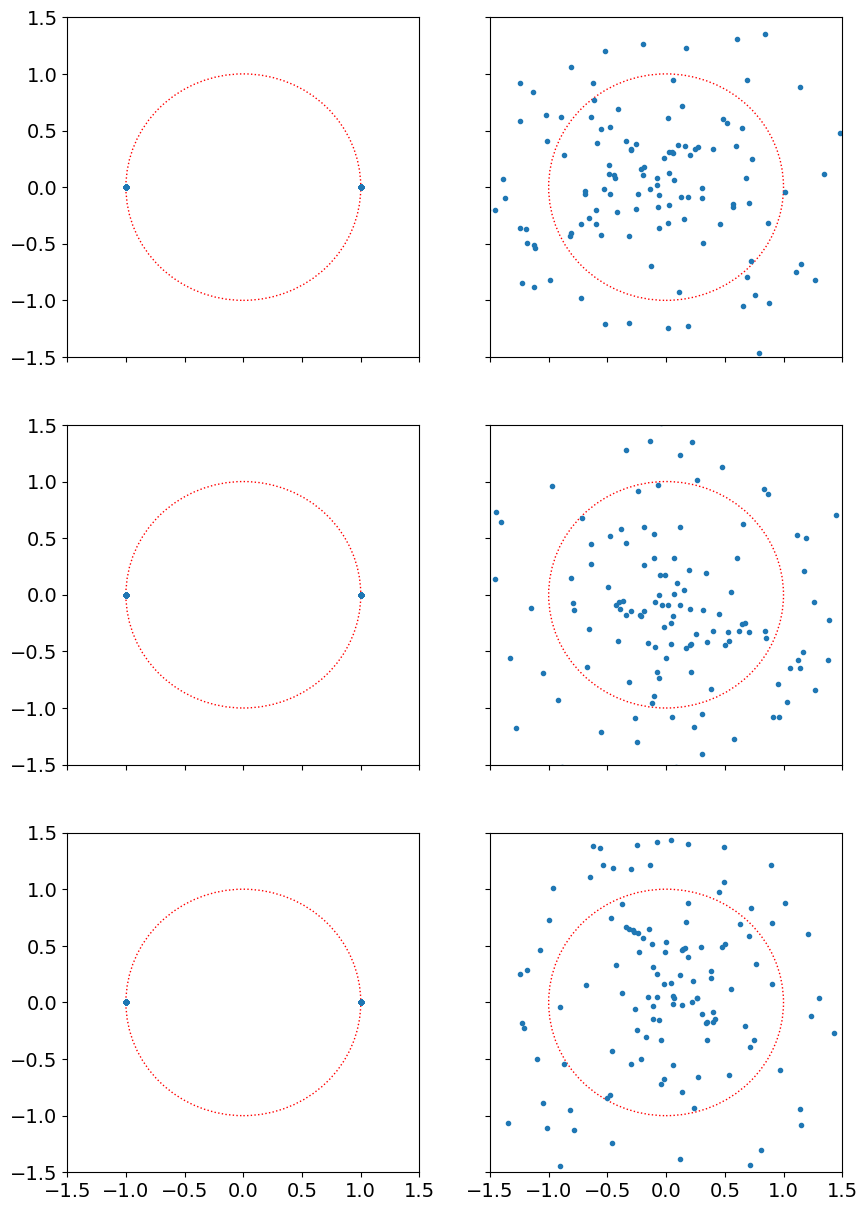

In [46]:
from scipy import signal
#SCO = 1.000001
SCO = 1.000003
CFO_fine = 0.7e3 # Hz
CFO_coarse = 60e3 # Hz
n_symbols = 3

# TX
test_symbol_freq = np.zeros(Tu)
test_symbol_freq[subcarriers_ss] = PSS[0]
test_symbol_time = np.fft.ifft(np.fft.fftshift(test_symbol_freq))
test_symbol_time_cp = np.hstack([test_symbol_time[-cp2:], test_symbol_time])
fig, axs = plt.subplots(n_symbols, 2, figsize=(10, 5*n_symbols), facecolor='w', sharex=True, sharey=True)
signal_tx = 0
for i in range(3):
    axs[i,0].plot(PSS[0].real, PSS[0].imag, '.')
    axs[i,0].add_patch(plt.Circle((0, 0), 1, color='red', fill=False, linewidth=1, linestyle=':'))
    signal_tx = np.hstack([signal_tx, test_symbol_time_cp, np.ones(int(np.round(20e-3*fs)))])
# add imperfections
signal_tx *= np.exp(1j*2*np.pi * (CFO_coarse + CFO_fine)/fs * np.arange(len(signal_tx)))
print(f'resample from {len(signal_tx)} to {int(np.round(len(signal_tx)/SCO))} samples')
signal_tx = signal.resample(signal_tx, int(np.round(len(signal_tx)/SCO)))

# RX
signal_rx = signal_tx
if True:
    #cp based CFO, seems to work really well
    signal_rx_corrected = signal_rx * np.exp(-1j*2*np.pi * (CFO_coarse)/fs * np.arange(len(signal_rx))) 
    cfo_norm = np.angle(np.dot(signal_rx_corrected[:cp2], np.conj(signal_rx_corrected[Tu:][:cp2]))) / Tu
    cfo_hz = cfo_norm / (2*np.pi) * fs
    print(f'fine CFO is {cfo_hz} Hz')
else:
    cfo_hz = 0

t_offset = cp2//2 # advance half cp to avoid ISI
for i in range(n_symbols):
    symbol_time = signal_rx[t_offset:][:Tu]

    # CFO compensation by multiplication
    # this needs a phase compensation -> is done in freq domain by multiplication
    symbol_time *= np.exp(-1j*2*np.pi * (CFO_coarse - cfo_hz)/fs * np.arange(len(symbol_time))) 

    test_symbol_rcv = np.fft.fftshift(np.fft.fft(symbol_time))
    # compensates phase that is generated by having cp/2 at the beginning of symbol
    test_symbol_rcv *= np.exp(1j*2*np.pi*(cp2//2)/Tu*np.arange(len(test_symbol_rcv))) 

    if True:
        # delay compensation, necessary if SCO is present
        lse = test_symbol_rcv[subcarriers_ss] * PSS[0]
        sum = 0
        for j in np.arange(1, len(lse)):
            sum += lse[j]*np.conj(lse[j-1])
        delay_norm = np.arctan2(np.imag(sum), np.real(sum))/(2*np.pi)
        print(f'delay is {delay_norm} = {delay_norm/SCS*1e6} us')
        test_symbol_rcv *= np.exp(-1j*2*np.pi*delay_norm*(np.arange(len(test_symbol_rcv))))

    # removes phase generated by CFO correction
    phase_compensation = np.exp(-1j*2*np.pi * (CFO_coarse - cfo_hz) * t_offset / fs)
    test_symbol_rcv *= phase_compensation

    # remaining phase offset is due to CFO_fine
    # TODO: implement CFO_fine correction

    axs[i,1].plot(test_symbol_rcv[subcarriers_ss].real, test_symbol_rcv[subcarriers_ss].imag, '.')
    axs[i,1].add_patch(plt.Circle((0, 0), 1, color='red', fill=False, linewidth=1, linestyle=':'))
    axs[i,1].set_xlim([-1.5, 1.5])
    axs[i,1].set_ylim([-1.5, 1.5])
    t_offset += int(np.round(20e-3*fs)) + Tu + cp2 


In [42]:
n_SSBs = x.size // int(fs * 20e-3)
syms_pss = np.empty((n_SSBs, 126), 'complex')
syms_sss = np.empty((n_SSBs, 126), 'complex')
offset_SSS = (Tu + (cp2+Tu) + cp2)
no_dc = np.concatenate((np.arange(63), np.arange(64, 127)))
skip_samples_acc = int(0)
t_offset = int(cp2//2)
samp_rate_error = 1
for j in range(n_SSBs):
    t_offset += int(round(20e-3 * fs))
    if True:
        symbol_pss = np.fft.fftshift(np.fft.fft(x[t_offset:][:Tu]))
        symbol_sss = np.fft.fftshift(np.fft.fft(x[t_offset + offset_SSS:][:Tu]))
        symbol_pss *= np.exp(1j*2*np.pi*(cp2//2)/Tu*(np.arange(len(symbol_pss))))
        symbol_sss *= np.exp(1j*2*np.pi*(cp2//2)/Tu*(np.arange(len(symbol_sss))))
        # delay compensation like in srsRAN in method ssb_measure()
        # this compensates sample rate errors
        lse = symbol_pss[subcarriers_ss] * PSS[N_id_2]
        sum = 0
        for i in np.arange(1, len(lse)):
            sum += lse[i]*np.conj(lse[i-1])
        delay_norm = np.arctan2(np.imag(sum), np.real(sum))/(2*np.pi)
        #print(f"PSS based delay for SSB nr {j} is {delay_norm/SCS*1e6:.06f} us (srsRAN method)")        
        symbol_pss *= np.exp(-1j*2*np.pi*delay_norm*(np.arange(len(symbol_pss))))
        symbol_sss *= np.exp(-1j*2*np.pi*delay_norm*(np.arange(len(symbol_pss))))
        skip_samples = -int(np.round(delay_norm / SCS * fs))
        if skip_samples_acc + skip_samples >= 0:
            t_offset += skip_samples
            if np.abs(skip_samples) > 0:
                # it is not possible to shift more than 1/fs by doing multiplication with e^jwt
                symbol_pss = np.fft.fftshift(np.fft.fft(x[t_offset:][:Tu]))
                symbol_sss = np.fft.fftshift(np.fft.fft(x[t_offset + offset_SSS:][:Tu]))
                symbol_pss *= np.exp(1j*2*np.pi*skip_samples/2/Tu*(np.arange(len(symbol_pss))))
                symbol_sss *= np.exp(1j*2*np.pi*skip_samples/2/Tu*(np.arange(len(symbol_sss))))
                lse = symbol_pss[subcarriers_ss] * PSS[N_id_2]
                sum = 0
                for i in np.arange(1, len(lse)):
                    sum += lse[i]*np.conj(lse[i-1])
                delay_norm = np.arctan2(np.imag(sum), np.real(sum))/(2*np.pi)
                symbol_pss *= np.exp(-1j*2*np.pi*delay_norm*(np.arange(len(symbol_pss))))
                symbol_sss *= np.exp(-1j*2*np.pi*delay_norm*(np.arange(len(symbol_pss))))
                #print(f'SSB {j} skipping {skip_samples} samples')
    else:
        symbol_pss = np.fft.fftshift(np.fft.fft(x[skip_samples_acc + round(20e-3 * fs * j * samp_rate_error):][:Tu]))
        symbol_sss = np.fft.fftshift(np.fft.fft(x[skip_samples_acc + offset_SSS + round(20e-3 * fs * j * samp_rate_error):][:Tu]))
    syms_pss[j] = symbol_pss[subcarriers_ss][no_dc]
    syms_pss[j] /= max(syms_pss[j].real.max(), syms_pss[j].imag.max())
    syms_sss[j] = symbol_sss[subcarriers_ss][no_dc]
    syms_sss[j] /= max(syms_sss[j].real.max(), syms_sss[j].imag.max())

Text(0.5, 0.91, 'PSS symbols (without equalization)')

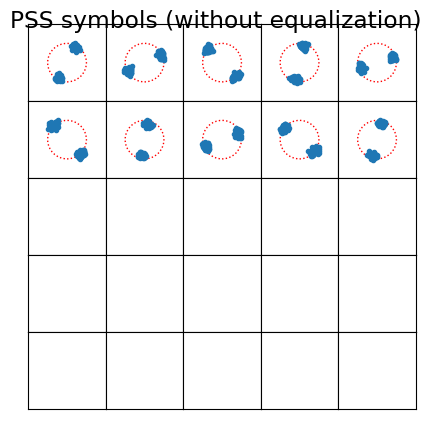

In [25]:
n = int(min(int(np.sqrt(n_SSBs)),5))
fig, axs = plt.subplots(n, n, figsize=(n, n), facecolor='w', sharex=True, sharey=True)
for j in range(2):
    for k in range(n):
        if (n == 1):
            ax = axs
        else:
            ax = axs[j, k]
        idx = n * j + k
        syms = syms_pss[idx]
        ax.plot(syms.real, syms.imag, '.')
        ax.add_patch(plt.Circle((0, 0), 1, color='red', fill=False, linewidth=1, linestyle=':'))
        ax.set_xlim((-2, 2))
        ax.set_ylim((-2, 2))
        ax.set_xticks([])
        ax.set_yticks([])
        
fig.subplots_adjust(hspace=0, wspace=0)
fig.suptitle('PSS symbols (without equalization)', y=0.91)

Text(0.5, 0.91, 'SSS symbols (without equalization)')

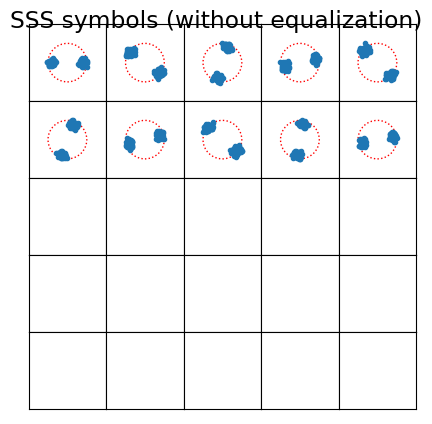

In [26]:
n = int(min(int(np.sqrt(n_SSBs)),5))
fig, axs = plt.subplots(n, n, figsize=(n, n), facecolor='w', sharex=True, sharey=True)
for j in range(2):
    for k in range(n):
        if (n == 1):
            ax = axs
        else:
            ax = axs[j, k]
        idx = n * j + k
        syms = syms_sss[idx]
        ax.plot(syms.real, syms.imag, '.')
        ax.add_patch(plt.Circle((0, 0), 1, color='red', fill=False, linewidth=1, linestyle=':'))
        ax.set_xlim((-2, 2))
        ax.set_ylim((-2, 2))
        ax.set_xticks([])
        ax.set_yticks([])
        
fig.subplots_adjust(hspace=0, wspace=0)
fig.suptitle('SSS symbols (without equalization)', y=0.91)

In [27]:
# defined in 3GPP TS 38.211 version 16.3.0 Release 16
def calc_m_seq_0():
    n = 127
    x = np.zeros(n, 'int32')    # m-sequence    
    x[0:7] = np.array([1, 0, 0, 0, 0, 0, 0])
    for i in np.arange(0, n - 7):
        x[i+7] = (x[i + 4] + x[i]) % 2    
    return x

def calc_m_seq_1():
    n = 127
    x = np.zeros(n, 'int32')    # m-sequence
    x[0:7] = np.array([1, 0, 0, 0, 0, 0, 0])
    for i in np.arange(0, n - 7):
        x[i+7] = (x[i + 1] + x[i]) % 2        
    return x

def gold(N_id_1, N_id_2):
    n = 127
    x_0 = calc_m_seq_0()
    x_1 = calc_m_seq_1()
    d_SSS = np.zeros(n, 'int32')    
    m_0 = 15*int((N_id_1/112)) + 5*N_id_2
    m_1 = N_id_1 % 112
    for n in np.arange(0, 127):
        d_SSS[n] = (1 - 2*x_0[(n + m_0) % 127]) * (1 - 2*x_1[(n + m_1) % 127])
    return d_SSS

SSS = np.zeros((336, 127))
for i in range(336):
    SSS[i, :] = gold(i, N_id_2)

In [28]:
#SSS_corr = np.sum(x_orig[a0 + round(5e-3 * fs * j * samp_rate_error):][:Tu] * np.conjugate(SSS), axis=1)
#t_corr = np.arange(SSS_corr.shape[1])/fs
SSS_corr = np.empty(336, 'complex')
for i in range(SSS_corr.shape[0]):
    SSS_corr[i] = np.sum(syms_sss[0] * np.conj(SSS[i][no_dc]), axis=0)
N_id_1 = np.argmax(np.abs(SSS_corr))
N_id = 3*N_id_1 + N_id_2
print(f'N_id = {N_id} (N_id_1 = {N_id_1}, N_id_2 = {N_id_2})')

N_id = 967 (N_id_1 = 322, N_id_2 = 1)


In [29]:
# CFO estimation in frequency domain
lse_pss = syms_pss[0] * PSS[N_id_2][no_dc]
lse_sss = syms_sss[0] * SSS[N_id_1][no_dc]
corr1 = np.sum(lse_pss)
corr2 = np.sum(lse_sss)
tmp = corr1*np.conj(corr2)
pss_sss_distance = (cp2 + Tu + cp2 + Tu)/fs
cfo_hz_max = 1/pss_sss_distance
cfo_hz = np.arctan2(np.imag(tmp), np.real(tmp)) / (2*np.pi) * cfo_hz_max
print(f'CFO is {cfo_hz}')

CFO is -4549.4513585012355
